# Setup
## Constants

In [1]:
!pip install transformers -q
!pip install torch -q
!pip install torchvision -q

In [2]:
# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = True

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# samples per class in uniform dataset
N_SAMPLES = 400

# path to dataset (do not change)
HM_DATA_PATH = "../dataset/"

# path to pth saves (do not change)
PTH_SAVE_PATH = "../pth/"

## Imports

In [3]:
import os, sys, random, importlib, transformers, itertools, copy
import numpy as np, torch.nn as nn, torch, seaborn as sns, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
print(os.getcwd())# Our own files
# sys.path.append('./src/')
import model_functions, utils, training, datasets
def set_seed(seed):# reproducable
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(0)

/home/jupyter/DD2430_Project/src


In [4]:
def update():# if you change our files
    import model_functions, utils, training, datasets
    for lib in [model_functions, utils, training, datasets]:
        importlib.reload(lib)# issues with not updating
update()

In [5]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available(): # For apple silicon
    device = 'mps'
print("Using device:", device)

Using device: cuda


In [6]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


# Dataset

### Full dataset, run once

In [7]:
column_name = 'garment_group_name'

In [8]:
df = pd.read_csv(HM_DATA_PATH+'articles_filtered.csv')
embs = torch.load(HM_DATA_PATH+'embedds.pth', weights_only=True) # all 100k embeddings
labs = torch.load(HM_DATA_PATH+'labels.pth', weights_only=True).tolist() #  100k labels
hmd = datasets.HMDatasetDuplicates(embs, np.array(labs), df)
print(hmd.article_id2suclass(694805002, column_name))
print(len(labs))
BALANCED = False

Knitwear
105099


In [9]:
update()
set_sizes = {"train": 0.8, "val": 0.1}
data = datasets.datasets(embs, np.array(labs), df, set_sizes, True)# takes 3 min

47071 Train size: 37656, Val size: 4707, Test size: 4708
105099
This should be empty set() set()
The resulting sizes 84230 4707 4708


### Subsets

In [10]:
exclude_classes = [
    "Unknown",
    "Special Offers",
    "Woven/Jersey/Knitted mix Baby",
]

In [12]:
batch_size = 256

In [13]:
update()
dataloaders_imbalanced = datasets.get_dataloaders(column_name, data, 5000, exclude_classes, batch_size)# look at Resource Utilization to see if capping

100%|██████████| 84230/84230 [00:39<00:00, 2135.88it/s]


Final class count for train: {'Knitwear': 5000, 'Shorts': 1272, 'Trousers Denim': 2451, 'Blouses': 4680, 'Dressed': 694, 'Socks and Tights': 1814, 'Shirts': 1711, 'Skirts': 986, 'Dresses/Skirts girls': 1169, 'Shoes': 4018, 'Trousers': 5000, 'Accessories': 5000, 'Swimwear': 2250, 'Under-, Nightwear': 5000, 'Outdoor': 3604, 'Dresses Ladies': 3931, 'Jersey Fancy': 5000, 'Jersey Basic': 5000}


100%|██████████| 4707/4707 [00:02<00:00, 2167.26it/s]


Final class count for val: {'Knitwear': 309, 'Shorts': 45, 'Trousers Denim': 136, 'Blouses': 292, 'Dressed': 55, 'Socks and Tights': 59, 'Shirts': 80, 'Skirts': 70, 'Dresses/Skirts girls': 90, 'Shoes': 243, 'Trousers': 305, 'Accessories': 634, 'Swimwear': 122, 'Under-, Nightwear': 266, 'Outdoor': 243, 'Dresses Ladies': 248, 'Jersey Fancy': 896, 'Jersey Basic': 187}


100%|██████████| 4708/4708 [00:02<00:00, 2155.22it/s]


Final class count for test: {'Knitwear': 300, 'Shorts': 59, 'Trousers Denim': 133, 'Blouses': 315, 'Dressed': 53, 'Socks and Tights': 59, 'Shirts': 77, 'Skirts': 74, 'Dresses/Skirts girls': 98, 'Shoes': 292, 'Trousers': 307, 'Accessories': 640, 'Swimwear': 111, 'Under-, Nightwear': 267, 'Outdoor': 255, 'Dresses Ladies': 256, 'Jersey Fancy': 811, 'Jersey Basic': 190}


In [14]:
BALANCED = False
dataloaders = dataloaders_imbalanced

## LoRA experiments on garment_group_name

In [15]:
file_name = "lora-cap-5000-2-120-start_lora.pth"

Lora, unweighed, no hard mining

In [26]:

def run_lora(weighted, hard_mining, fc=False):
    update()

    ranks = [0, 0, 0, 0, 0, 0,0, 0,0, 0, 256, 256]  # Only apply LoRA with rank 64 to the last layer

    #ranks = [256, 256, 256, 256, 256, 256, 256, 256,256, 256, 256, 256]  # Only apply LoRA with rank 64 to the last layer
    lr = 1e-04
    wd = 0.001
    epochs_num = 100
    lora_layers = []

    clip = {'m': copy.deepcopy(model), 'p': processor} # do not load each time
    lora_layers = model_functions.apply_lora_to_transformer(clip['m'].text_model.encoder.layers , lora_layers, ranks)
    lora_params_attention = model_functions.get_lora_params(clip['m'], print_layer = True)


    ft = training.FinetuneCLIP(dataloaders, clip, epochs = epochs_num )
    ft.conf = {'epochs': epochs_num, 'balanced':BALANCED}
    ft.model_prefix = f"draft-experiments/weighted={weighted}_hard-mining={hard_mining}_fc={fc}"
    ft.hard_mining = hard_mining
    ft.weighted = weighted

    # Initialize LoRA training with current hyperparameters
    ft.tt['soft'], ft.tt['LoRA'], ft.tt['image_fc'] = 0, 1, 0 # Enable LoRA
    if fc:
        ft.tt['image_fc'] = 1


    ft.initialize({'LoRA': lora_params_attention, 'lr': lr, 'weight_decay': wd, 'num_soft':0, 'add':''},
                load=False, file_name=file_name)


    # ft.count_parameters()
    #all_predictions, all_labels, acc = ft.eval(False)

    # Train the model
    ft.es['pat']=30
    ft.train()

    # Evaluate the model
    all_predictions, all_labels, acc = ft.eval(False)
    utils.confussion_matrix(all_labels, all_predictions, list(dataloaders['test'].dataset.class_to_id.keys()), F1=False)
    ft.plot_loss_key('train', 'final')
    ft.plot_loss_key('val', 'final')

    print(f"Accuracy for {ft.model_prefix} is {acc:.2f}%")

text_model.encoder.layers.10.self_attn.k_proj.lora_A
text_model.encoder.layers.10.self_attn.k_proj.lora_B
text_model.encoder.layers.10.self_attn.v_proj.lora_A
text_model.encoder.layers.10.self_attn.v_proj.lora_B
text_model.encoder.layers.10.self_attn.q_proj.lora_A
text_model.encoder.layers.10.self_attn.q_proj.lora_B
text_model.encoder.layers.10.self_attn.out_proj.lora_A
text_model.encoder.layers.10.self_attn.out_proj.lora_B
text_model.encoder.layers.11.self_attn.k_proj.lora_A
text_model.encoder.layers.11.self_attn.k_proj.lora_B
text_model.encoder.layers.11.self_attn.v_proj.lora_A
text_model.encoder.layers.11.self_attn.v_proj.lora_B
text_model.encoder.layers.11.self_attn.q_proj.lora_A
text_model.encoder.layers.11.self_attn.q_proj.lora_B
text_model.encoder.layers.11.self_attn.out_proj.lora_A
text_model.encoder.layers.11.self_attn.out_proj.lora_B


Training:  80%|████████  | 80/100 [45:34<11:15, 33.80s/epoch, Patience=3 / 30] 

Evaluating Model at Epoch 80



100%|██████████| 17/17 [00:00<00:00, 45.75it/s]


Accuracy 66.930419921875



100%|██████████| 17/17 [00:00<00:00, 46.22it/s]


Accuracy 66.930419921875
Accuracy of baseline is 66.93% at epoch 80


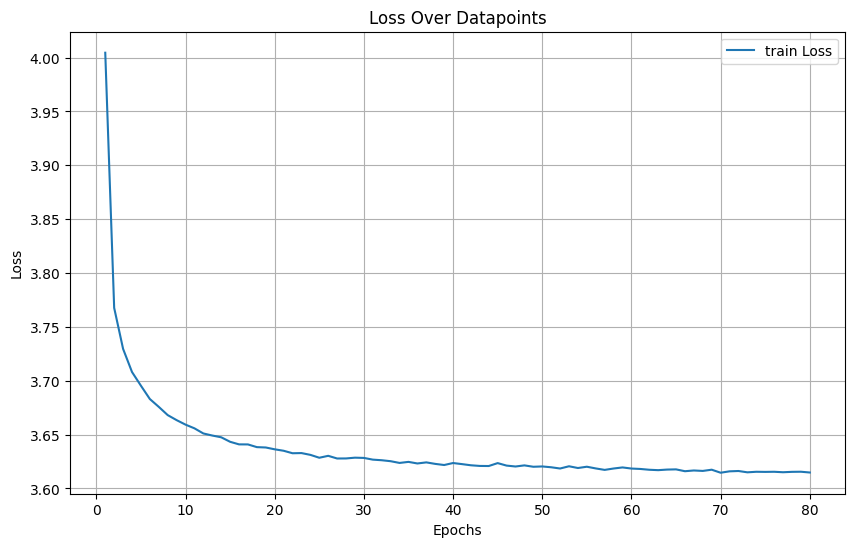

<Figure size 640x480 with 0 Axes>

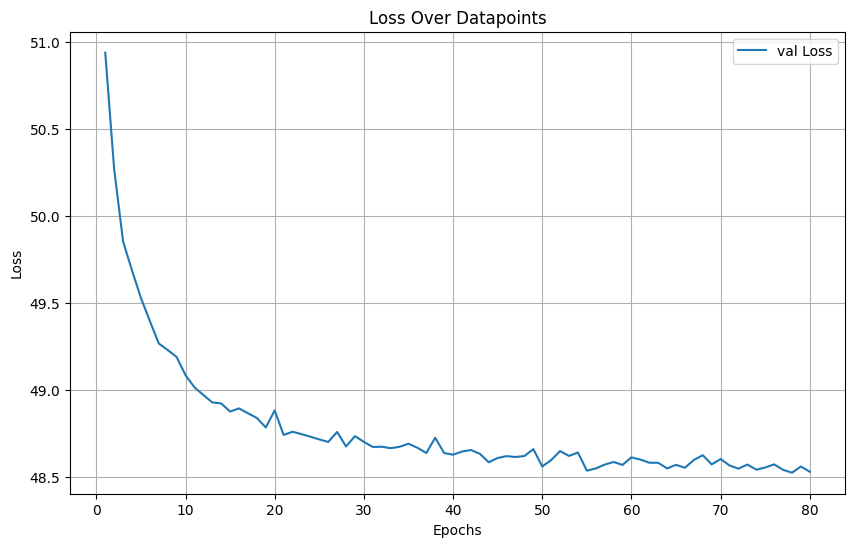

Training:  90%|█████████ | 90/100 [51:07<05:32, 33.21s/epoch, Patience=13 / 30]

Evaluating Model at Epoch 90



100%|██████████| 17/17 [00:00<00:00, 45.38it/s]


Accuracy 66.83732604980469



100%|██████████| 17/17 [00:00<00:00, 46.03it/s]

Accuracy 66.83732604980469
Accuracy of baseline is 66.84% at epoch 90


<Figure size 640x480 with 0 Axes>

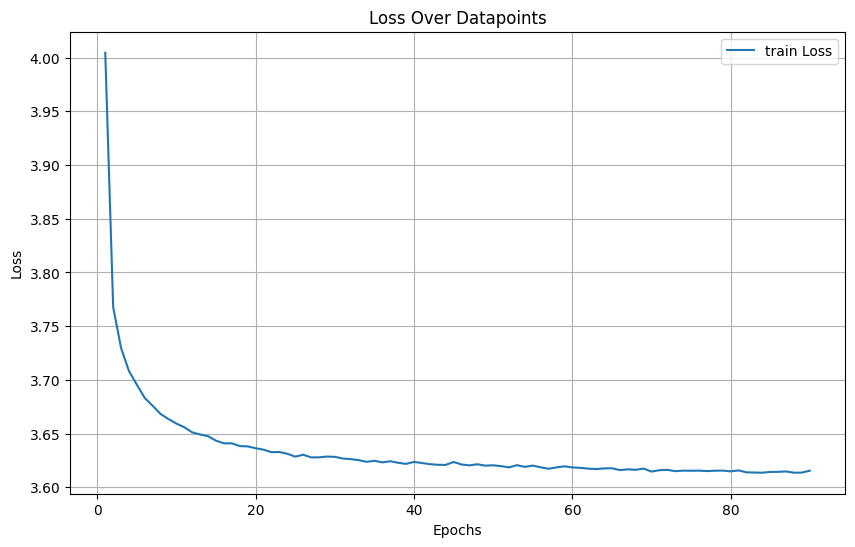

<Figure size 640x480 with 0 Axes>

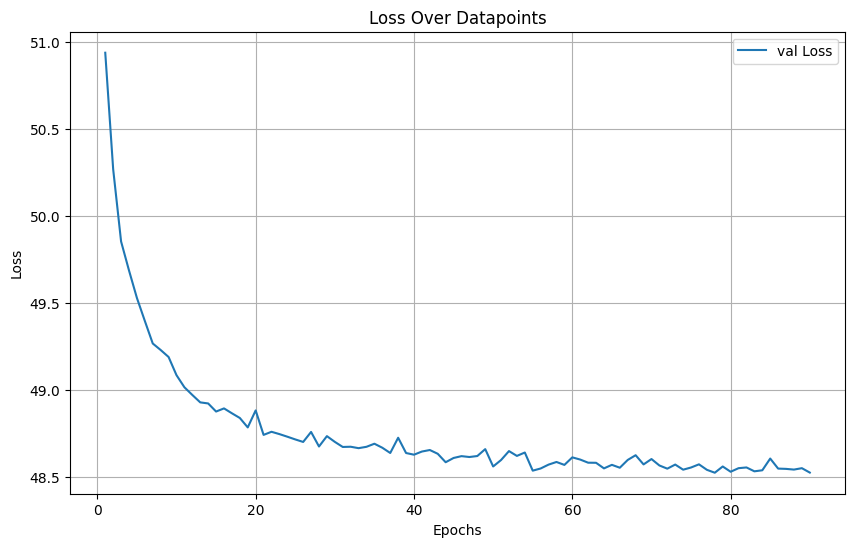

100%|██████████| 17/17 [00:00<00:00, 46.84it/s]


Accuracy 66.97695922851562


<Figure size 640x480 with 0 Axes>

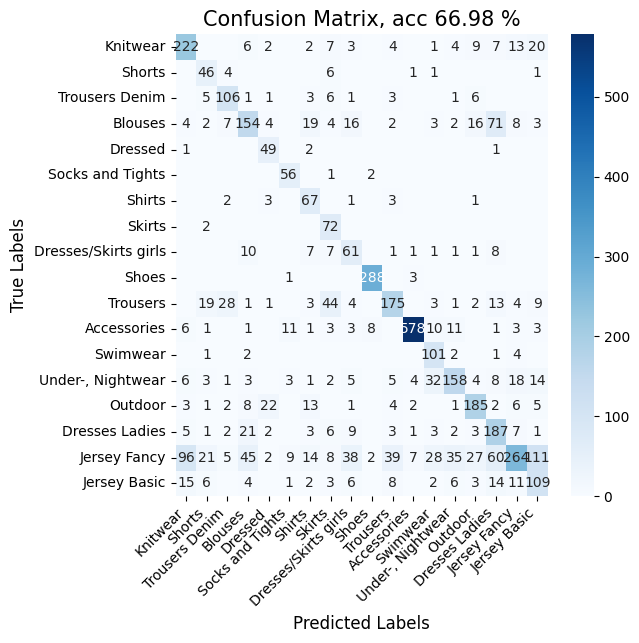

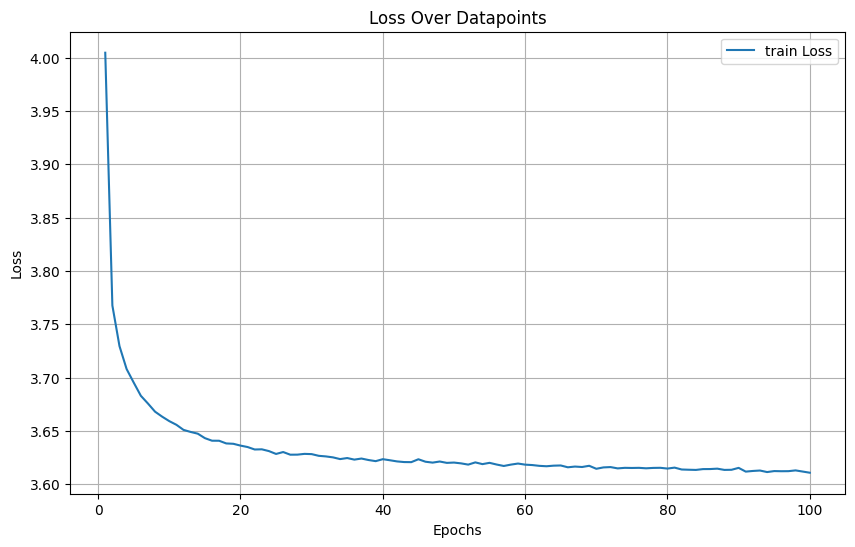

<Figure size 640x480 with 0 Axes>

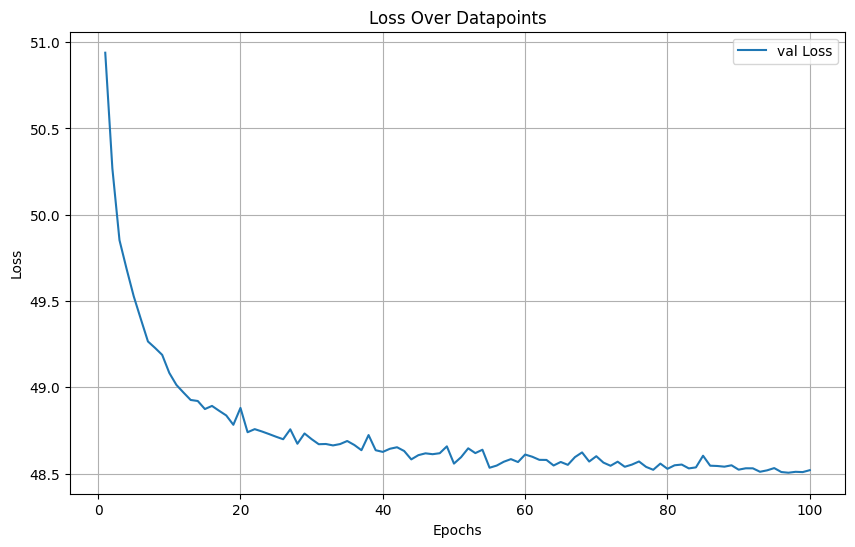

Accuracy for draft-experiments/weighted=False_hard-mining=False_fc=False is 66.98%
text_model.encoder.layers.10.self_attn.k_proj.lora_A
text_model.encoder.layers.10.self_attn.k_proj.lora_B
text_model.encoder.layers.10.self_attn.v_proj.lora_A
text_model.encoder.layers.10.self_attn.v_proj.lora_B
text_model.encoder.layers.10.self_attn.q_proj.lora_A
text_model.encoder.layers.10.self_attn.q_proj.lora_B
text_model.encoder.layers.10.self_attn.out_proj.lora_A
text_model.encoder.layers.10.self_attn.out_proj.lora_B
text_model.encoder.layers.11.self_attn.k_proj.lora_A
text_model.encoder.layers.11.self_attn.k_proj.lora_B
text_model.encoder.layers.11.self_attn.v_proj.lora_A
text_model.encoder.layers.11.self_attn.v_proj.lora_B
text_model.encoder.layers.11.self_attn.q_proj.lora_A
text_model.encoder.layers.11.self_attn.q_proj.lora_B
text_model.encoder.layers.11.self_attn.out_proj.lora_A
text_model.encoder.layers.11.self_attn.out_proj.lora_B


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Suggested threshold for hard examples: 4.8066169763191064
Epoch 0: Max loss encountered = 7.487217903137207, Hard sample threshold set to 5.989774322509766


Training:  10%|█         | 10/100 [05:46<52:08, 34.76s/epoch, Patience=0 / 30]

Suggested threshold for hard examples: 3.7898287467620455
Epoch 10: Max loss encountered = 3.896314859390259, Hard sample threshold set to 3.1170518875122073


Training:  11%|█         | 11/100 [06:23<52:29, 35.39s/epoch, Patience=1 / 30]

Epoch 11: Training on hard samples - Max allowed = 500, Current count = 229


Training:  12%|█▏        | 12/100 [07:15<59:12, 40.37s/epoch, Patience=0 / 30]

Epoch 12: Training on hard samples - Max allowed = 500, Current count = 458


Training:  13%|█▎        | 13/100 [08:28<1:13:01, 50.37s/epoch, Patience=1 / 30]

Epoch 13: Training on hard samples - Max allowed = 500, Current count = 500


Training:  14%|█▍        | 14/100 [09:42<1:22:03, 57.25s/epoch, Patience=0 / 30]

Epoch 14: Training on hard samples - Max allowed = 500, Current count = 500


Training:  15%|█▌        | 15/100 [10:58<1:29:29, 63.17s/epoch, Patience=1 / 30]

Epoch 15: Training on hard samples - Max allowed = 500, Current count = 500


Training:  16%|█▌        | 16/100 [12:11<1:32:31, 66.08s/epoch, Patience=0 / 30]

Epoch 16: Training on hard samples - Max allowed = 500, Current count = 500


Training:  17%|█▋        | 17/100 [13:28<1:35:52, 69.30s/epoch, Patience=1 / 30]

Epoch 17: Training on hard samples - Max allowed = 500, Current count = 500


Training:  18%|█▊        | 18/100 [14:41<1:36:17, 70.45s/epoch, Patience=0 / 30]

Epoch 18: Training on hard samples - Max allowed = 500, Current count = 500


Training:  19%|█▉        | 19/100 [15:58<1:37:35, 72.29s/epoch, Patience=1 / 30]

Epoch 19: Training on hard samples - Max allowed = 500, Current count = 500


Training:  20%|██        | 20/100 [17:11<1:36:35, 72.44s/epoch, Patience=2 / 30]

Suggested threshold for hard examples: 3.7590512236442084
Epoch 20: Max loss encountered = 3.800429105758667, Hard sample threshold set to 3.0403432846069336
Epoch 20: Training on hard samples - Max allowed = 520, Current count = 520


Training:  21%|██        | 21/100 [18:25<1:36:05, 72.98s/epoch, Patience=3 / 30]

Epoch 21: Training on hard samples - Max allowed = 520, Current count = 520


Training:  22%|██▏       | 22/100 [19:39<1:35:23, 73.37s/epoch, Patience=0 / 30]

Epoch 22: Training on hard samples - Max allowed = 520, Current count = 520


Training:  23%|██▎       | 23/100 [20:57<1:35:57, 74.78s/epoch, Patience=1 / 30]

Epoch 23: Training on hard samples - Max allowed = 540, Current count = 540


Training:  24%|██▍       | 24/100 [22:13<1:35:13, 75.18s/epoch, Patience=0 / 30]

Epoch 24: Training on hard samples - Max allowed = 540, Current count = 540


Training:  25%|██▌       | 25/100 [23:33<1:35:43, 76.58s/epoch, Patience=1 / 30]

Epoch 25: Training on hard samples - Max allowed = 540, Current count = 540


Training:  26%|██▌       | 26/100 [24:49<1:34:11, 76.38s/epoch, Patience=2 / 30]

Epoch 26: Training on hard samples - Max allowed = 560, Current count = 560


Training:  27%|██▋       | 27/100 [26:06<1:33:11, 76.60s/epoch, Patience=0 / 30]

Epoch 27: Training on hard samples - Max allowed = 560, Current count = 560


Training:  28%|██▊       | 28/100 [27:27<1:33:31, 77.94s/epoch, Patience=1 / 30]

Epoch 28: Training on hard samples - Max allowed = 580, Current count = 580


Training:  29%|██▉       | 29/100 [28:46<1:32:41, 78.33s/epoch, Patience=0 / 30]

Epoch 29: Training on hard samples - Max allowed = 580, Current count = 580


Training:  30%|███       | 30/100 [30:09<1:32:56, 79.66s/epoch, Patience=1 / 30]

Suggested threshold for hard examples: 3.7481174259311008
Epoch 30: Max loss encountered = 3.7983806133270264, Hard sample threshold set to 3.038704490661621
Epoch 30: Training on hard samples - Max allowed = 600, Current count = 600


Training:  31%|███       | 31/100 [31:30<1:31:54, 79.93s/epoch, Patience=0 / 30]

Epoch 31: Training on hard samples - Max allowed = 600, Current count = 600


Training:  32%|███▏      | 32/100 [32:54<1:32:09, 81.31s/epoch, Patience=1 / 30]

Epoch 32: Training on hard samples - Max allowed = 620, Current count = 620


Training:  33%|███▎      | 33/100 [34:17<1:31:16, 81.74s/epoch, Patience=0 / 30]

Epoch 33: Training on hard samples - Max allowed = 620, Current count = 620


Training:  34%|███▍      | 34/100 [35:43<1:31:19, 83.03s/epoch, Patience=1 / 30]

Epoch 34: Training on hard samples - Max allowed = 620, Current count = 620


Training:  35%|███▌      | 35/100 [37:05<1:29:39, 82.76s/epoch, Patience=2 / 30]

Epoch 35: Training on hard samples - Max allowed = 640, Current count = 640


Training:  36%|███▌      | 36/100 [38:29<1:28:38, 83.10s/epoch, Patience=3 / 30]

Epoch 36: Training on hard samples - Max allowed = 640, Current count = 640


Training:  37%|███▋      | 37/100 [39:53<1:27:26, 83.27s/epoch, Patience=4 / 30]

Epoch 37: Training on hard samples - Max allowed = 660, Current count = 660


Training:  38%|███▊      | 38/100 [41:18<1:26:39, 83.86s/epoch, Patience=5 / 30]

Epoch 38: Training on hard samples - Max allowed = 660, Current count = 660


Training:  39%|███▉      | 39/100 [42:43<1:25:38, 84.24s/epoch, Patience=6 / 30]

Epoch 39: Training on hard samples - Max allowed = 680, Current count = 680


Training:  40%|████      | 40/100 [44:11<1:25:12, 85.22s/epoch, Patience=7 / 30]

Suggested threshold for hard examples: 3.7385361378099145
Epoch 40: Max loss encountered = 3.79888653755188, Hard sample threshold set to 3.039109230041504
Epoch 40: Training on hard samples - Max allowed = 670, Current count = 670


Training:  41%|████      | 41/100 [45:37<1:24:02, 85.47s/epoch, Patience=8 / 30]

Epoch 41: Training on hard samples - Max allowed = 690, Current count = 690


Training:  42%|████▏     | 42/100 [47:04<1:23:15, 86.14s/epoch, Patience=0 / 30]

Epoch 42: Training on hard samples - Max allowed = 690, Current count = 690


Training:  43%|████▎     | 43/100 [48:36<1:23:22, 87.77s/epoch, Patience=1 / 30]

Epoch 43: Training on hard samples - Max allowed = 690, Current count = 690


Training:  44%|████▍     | 44/100 [50:04<1:21:58, 87.83s/epoch, Patience=0 / 30]

Epoch 44: Training on hard samples - Max allowed = 690, Current count = 690


Training:  45%|████▌     | 45/100 [51:35<1:21:30, 88.93s/epoch, Patience=1 / 30]

Epoch 45: Training on hard samples - Max allowed = 690, Current count = 690


Training:  46%|████▌     | 46/100 [53:03<1:19:42, 88.56s/epoch, Patience=2 / 30]

Epoch 46: Training on hard samples - Max allowed = 710, Current count = 710


Training:  47%|████▋     | 47/100 [54:33<1:18:34, 88.96s/epoch, Patience=3 / 30]

Epoch 47: Training on hard samples - Max allowed = 730, Current count = 730


Training:  48%|████▊     | 48/100 [56:04<1:17:38, 89.58s/epoch, Patience=4 / 30]

Epoch 48: Training on hard samples - Max allowed = 750, Current count = 750


Training:  49%|████▉     | 49/100 [57:37<1:16:56, 90.51s/epoch, Patience=5 / 30]

Epoch 49: Training on hard samples - Max allowed = 770, Current count = 770


Training:  50%|█████     | 50/100 [59:11<1:16:17, 91.56s/epoch, Patience=0 / 30]

Suggested threshold for hard examples: 3.7482777472977884
Epoch 50: Max loss encountered = 3.797849655151367, Hard sample threshold set to 3.038279724121094
Epoch 50: Training on hard samples - Max allowed = 760, Current count = 760


Training:  51%|█████     | 51/100 [1:00:48<1:16:06, 93.19s/epoch, Patience=1 / 30]

Epoch 51: Training on hard samples - Max allowed = 780, Current count = 780


Training:  52%|█████▏    | 52/100 [1:02:23<1:14:56, 93.68s/epoch, Patience=0 / 30]

Epoch 52: Training on hard samples - Max allowed = 780, Current count = 780


Training:  53%|█████▎    | 53/100 [1:04:02<1:14:43, 95.40s/epoch, Patience=1 / 30]

Epoch 53: Training on hard samples - Max allowed = 800, Current count = 800


Training:  54%|█████▍    | 54/100 [1:05:38<1:13:22, 95.72s/epoch, Patience=0 / 30]

Epoch 54: Training on hard samples - Max allowed = 800, Current count = 800


Training:  55%|█████▌    | 55/100 [1:07:19<1:12:46, 97.03s/epoch, Patience=1 / 30]

Epoch 55: Training on hard samples - Max allowed = 800, Current count = 800


Training:  56%|█████▌    | 56/100 [1:08:55<1:11:04, 96.92s/epoch, Patience=2 / 30]

Epoch 56: Training on hard samples - Max allowed = 820, Current count = 820


Training:  57%|█████▋    | 57/100 [1:10:33<1:09:38, 97.18s/epoch, Patience=3 / 30]

Epoch 57: Training on hard samples - Max allowed = 840, Current count = 840


Training:  58%|█████▊    | 58/100 [1:12:13<1:08:32, 97.91s/epoch, Patience=4 / 30]

Epoch 58: Training on hard samples - Max allowed = 840, Current count = 840


Training:  59%|█████▉    | 59/100 [1:13:53<1:07:20, 98.55s/epoch, Patience=0 / 30]

Epoch 59: Training on hard samples - Max allowed = 840, Current count = 840


Training:  60%|██████    | 60/100 [1:15:36<1:06:35, 99.88s/epoch, Patience=1 / 30]

Suggested threshold for hard examples: 3.7431920154266303
Epoch 60: Max loss encountered = 3.7866194248199463, Hard sample threshold set to 3.029295539855957
Epoch 60: Training on hard samples - Max allowed = 860, Current count = 860


Training:  61%|██████    | 61/100 [1:17:17<1:05:10, 100.27s/epoch, Patience=2 / 30]

Epoch 61: Training on hard samples - Max allowed = 880, Current count = 880


Training:  62%|██████▏   | 62/100 [1:19:00<1:04:00, 101.08s/epoch, Patience=0 / 30]

Epoch 62: Training on hard samples - Max allowed = 880, Current count = 880


Training:  63%|██████▎   | 63/100 [1:20:46<1:03:18, 102.67s/epoch, Patience=1 / 30]

Epoch 63: Training on hard samples - Max allowed = 880, Current count = 880


Training:  64%|██████▍   | 64/100 [1:22:29<1:01:36, 102.68s/epoch, Patience=2 / 30]

Epoch 64: Training on hard samples - Max allowed = 900, Current count = 900


Training:  65%|██████▌   | 65/100 [1:24:14<1:00:16, 103.33s/epoch, Patience=0 / 30]

Epoch 65: Training on hard samples - Max allowed = 900, Current count = 900


Training:  66%|██████▌   | 66/100 [1:26:02<59:21, 104.75s/epoch, Patience=1 / 30]  

Epoch 66: Training on hard samples - Max allowed = 920, Current count = 920


Training:  67%|██████▋   | 67/100 [1:27:48<57:51, 105.21s/epoch, Patience=0 / 30]

Epoch 67: Training on hard samples - Max allowed = 920, Current count = 920


Training:  68%|██████▊   | 68/100 [1:29:38<56:49, 106.54s/epoch, Patience=1 / 30]

Epoch 68: Training on hard samples - Max allowed = 940, Current count = 940


Training:  69%|██████▉   | 69/100 [1:31:25<55:12, 106.85s/epoch, Patience=2 / 30]

Epoch 69: Training on hard samples - Max allowed = 960, Current count = 960


Training:  70%|███████   | 70/100 [1:33:15<53:47, 107.58s/epoch, Patience=0 / 30]

Suggested threshold for hard examples: 3.7344116066933726
Epoch 70: Max loss encountered = 3.8212594985961914, Hard sample threshold set to 3.0570075988769534
Epoch 70: Training on hard samples - Max allowed = 950, Current count = 950


Training:  71%|███████   | 71/100 [1:35:07<52:44, 109.13s/epoch, Patience=1 / 30]

Epoch 71: Training on hard samples - Max allowed = 970, Current count = 970


Training:  72%|███████▏  | 72/100 [1:36:57<51:04, 109.43s/epoch, Patience=0 / 30]

Epoch 72: Training on hard samples - Max allowed = 970, Current count = 970


Training:  73%|███████▎  | 73/100 [1:38:51<49:49, 110.72s/epoch, Patience=1 / 30]

Epoch 73: Training on hard samples - Max allowed = 970, Current count = 970


Training:  74%|███████▍  | 74/100 [1:40:41<47:53, 110.51s/epoch, Patience=2 / 30]

Epoch 74: Training on hard samples - Max allowed = 990, Current count = 990


Training:  75%|███████▌  | 75/100 [1:42:33<46:10, 110.81s/epoch, Patience=3 / 30]

Epoch 75: Training on hard samples - Max allowed = 990, Current count = 990


Training:  76%|███████▌  | 76/100 [1:44:25<44:29, 111.21s/epoch, Patience=4 / 30]

Epoch 76: Training on hard samples - Max allowed = 990, Current count = 990


Training:  77%|███████▋  | 77/100 [1:46:16<42:40, 111.34s/epoch, Patience=5 / 30]

Epoch 77: Training on hard samples - Max allowed = 1010, Current count = 1010


Training:  78%|███████▊  | 78/100 [1:48:10<41:00, 111.85s/epoch, Patience=6 / 30]

Epoch 78: Training on hard samples - Max allowed = 1010, Current count = 1010


Training:  79%|███████▉  | 79/100 [1:50:03<39:16, 112.19s/epoch, Patience=0 / 30]

Epoch 79: Training on hard samples - Max allowed = 1010, Current count = 1010


Training:  80%|████████  | 80/100 [1:51:59<37:50, 113.54s/epoch, Patience=1 / 30]

Suggested threshold for hard examples: 3.733941218225726
Epoch 80: Max loss encountered = 3.8121814727783203, Hard sample threshold set to 3.0497451782226563
Epoch 80: Training on hard samples - Max allowed = 1030, Current count = 1030
Evaluating Model at Epoch 80



100%|██████████| 17/17 [00:00<00:00, 47.19it/s]


Accuracy 65.79008483886719



100%|██████████| 17/17 [00:00<00:00, 47.57it/s]

Accuracy 65.79008483886719
Accuracy of baseline is 65.79% at epoch 80


<Figure size 640x480 with 0 Axes>

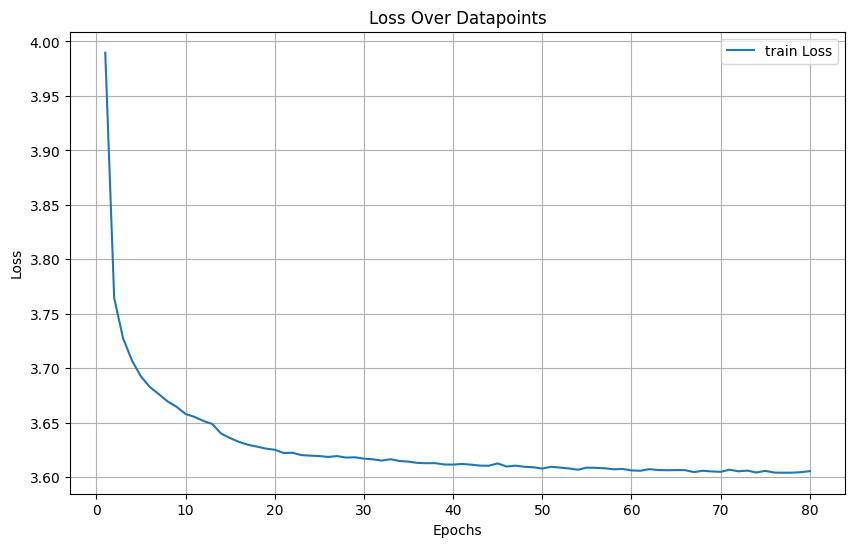

<Figure size 640x480 with 0 Axes>

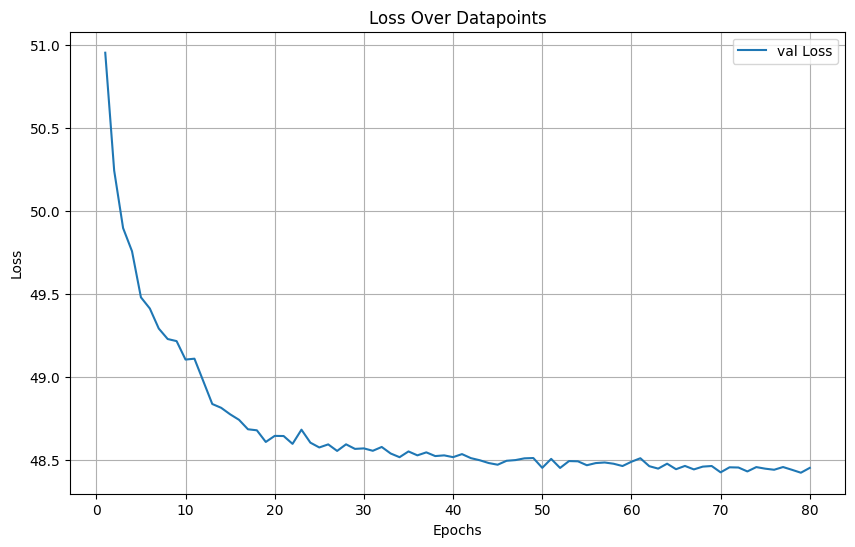

Training:  81%|████████  | 81/100 [1:53:56<36:18, 114.64s/epoch, Patience=0 / 30]

Epoch 81: Training on hard samples - Max allowed = 1030, Current count = 1030


Training:  82%|████████▏ | 82/100 [1:55:55<34:43, 115.77s/epoch, Patience=1 / 30]

Epoch 82: Training on hard samples - Max allowed = 1030, Current count = 1030


Training:  83%|████████▎ | 83/100 [1:57:50<32:42, 115.45s/epoch, Patience=2 / 30]

Epoch 83: Training on hard samples - Max allowed = 1050, Current count = 1050


Training:  84%|████████▍ | 84/100 [1:59:46<30:51, 115.71s/epoch, Patience=0 / 30]

Epoch 84: Training on hard samples - Max allowed = 1050, Current count = 1050


Training:  85%|████████▌ | 85/100 [2:01:46<29:15, 117.00s/epoch, Patience=1 / 30]

Epoch 85: Training on hard samples - Max allowed = 1070, Current count = 1070


Training:  86%|████████▌ | 86/100 [2:03:44<27:24, 117.45s/epoch, Patience=2 / 30]

Epoch 86: Training on hard samples - Max allowed = 1090, Current count = 1090


Training:  87%|████████▋ | 87/100 [2:05:43<25:33, 117.96s/epoch, Patience=3 / 30]

Epoch 87: Training on hard samples - Max allowed = 1090, Current count = 1090


Training:  88%|████████▊ | 88/100 [2:07:43<23:40, 118.37s/epoch, Patience=0 / 30]

Epoch 88: Training on hard samples - Max allowed = 1090, Current count = 1090


Training:  89%|████████▉ | 89/100 [2:09:46<21:57, 119.80s/epoch, Patience=1 / 30]

Epoch 89: Training on hard samples - Max allowed = 1110, Current count = 1110


Training:  90%|█████████ | 90/100 [2:11:47<20:02, 120.20s/epoch, Patience=0 / 30]

Suggested threshold for hard examples: 3.742706629536628
Epoch 90: Max loss encountered = 3.800140619277954, Hard sample threshold set to 3.0401124954223633
Epoch 90: Training on hard samples - Max allowed = 1100, Current count = 1100
Evaluating Model at Epoch 90



100%|██████████| 17/17 [00:00<00:00, 46.46it/s]


Accuracy 66.81405639648438



100%|██████████| 17/17 [00:00<00:00, 45.98it/s]

Accuracy 66.81405639648438
Accuracy of baseline is 66.81% at epoch 90


<Figure size 640x480 with 0 Axes>

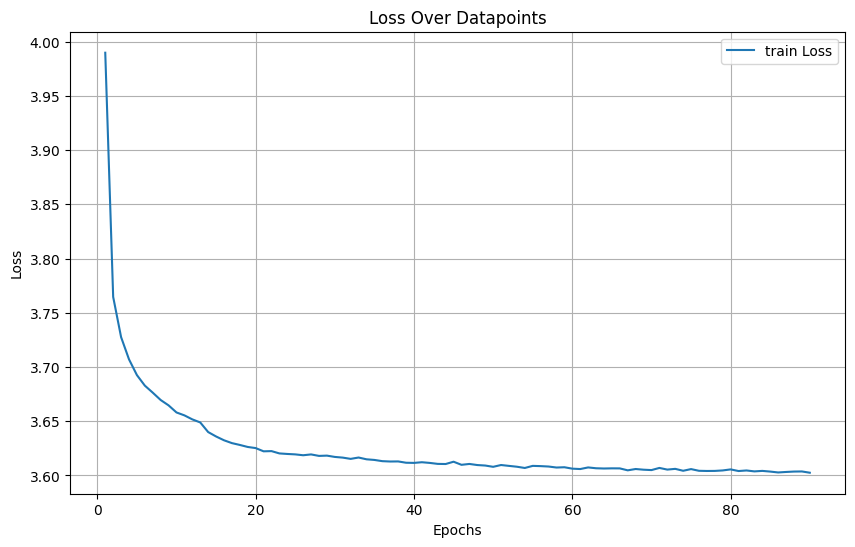

<Figure size 640x480 with 0 Axes>

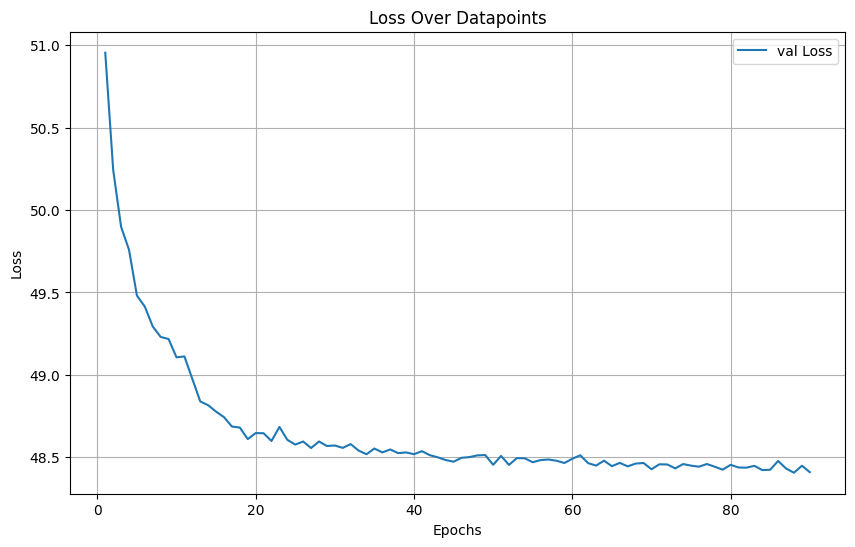

Training:  91%|█████████ | 91/100 [2:13:54<18:20, 122.23s/epoch, Patience=1 / 30]

Epoch 91: Training on hard samples - Max allowed = 1120, Current count = 1120


Training:  92%|█████████▏| 92/100 [2:15:56<16:17, 122.13s/epoch, Patience=2 / 30]

Epoch 92: Training on hard samples - Max allowed = 1140, Current count = 1140


Training:  93%|█████████▎| 93/100 [2:17:59<14:17, 122.51s/epoch, Patience=0 / 30]

Epoch 93: Training on hard samples - Max allowed = 1140, Current count = 1140


Training:  94%|█████████▍| 94/100 [2:20:07<12:23, 123.90s/epoch, Patience=1 / 30]

Epoch 94: Training on hard samples - Max allowed = 1160, Current count = 1160


Training:  95%|█████████▌| 95/100 [2:22:12<10:22, 124.46s/epoch, Patience=2 / 30]

Epoch 95: Training on hard samples - Max allowed = 1180, Current count = 1180


Training:  96%|█████████▌| 96/100 [2:24:20<08:21, 125.34s/epoch, Patience=3 / 30]

Epoch 96: Training on hard samples - Max allowed = 1180, Current count = 1180


Training:  97%|█████████▋| 97/100 [2:26:27<06:17, 125.80s/epoch, Patience=4 / 30]

Epoch 97: Training on hard samples - Max allowed = 1180, Current count = 1180


Training:  98%|█████████▊| 98/100 [2:28:34<04:12, 126.19s/epoch, Patience=5 / 30]

Epoch 98: Training on hard samples - Max allowed = 1200, Current count = 1200


Training:  99%|█████████▉| 99/100 [2:30:42<02:06, 126.92s/epoch, Patience=6 / 30]

Epoch 99: Training on hard samples - Max allowed = 1220, Current count = 1220


100%|██████████| 17/17 [00:00<00:00, 44.98it/s]


Accuracy 66.25552368164062


<Figure size 640x480 with 0 Axes>

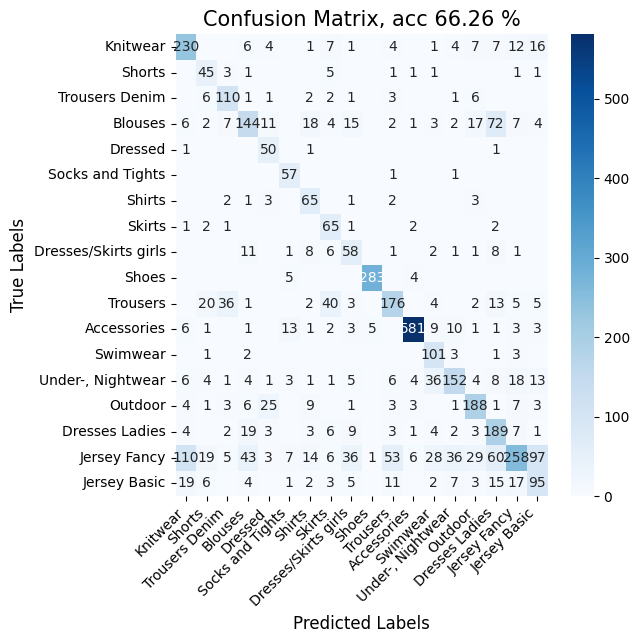

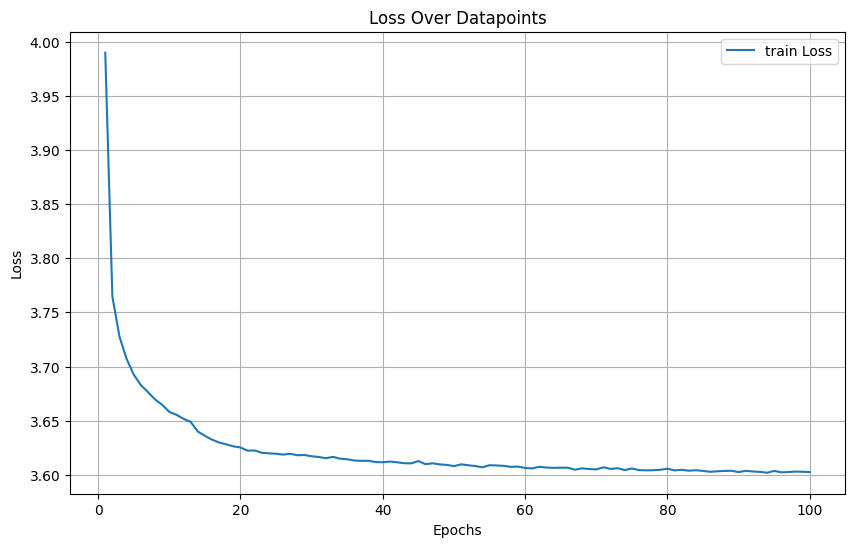

<Figure size 640x480 with 0 Axes>

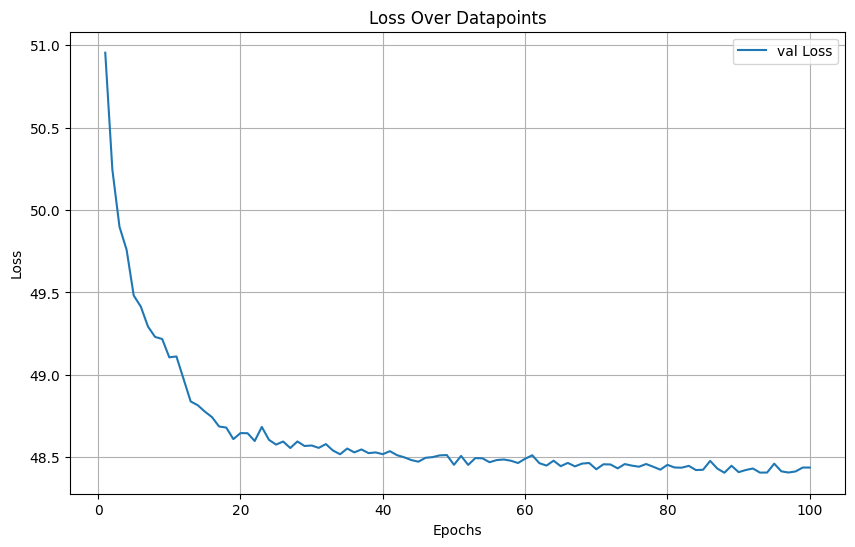

Accuracy for draft-experiments/weighted=False_hard-mining=True_fc=False is 66.26%
text_model.encoder.layers.10.self_attn.k_proj.lora_A
text_model.encoder.layers.10.self_attn.k_proj.lora_B
text_model.encoder.layers.10.self_attn.v_proj.lora_A
text_model.encoder.layers.10.self_attn.v_proj.lora_B
text_model.encoder.layers.10.self_attn.q_proj.lora_A
text_model.encoder.layers.10.self_attn.q_proj.lora_B
text_model.encoder.layers.10.self_attn.out_proj.lora_A
text_model.encoder.layers.10.self_attn.out_proj.lora_B
text_model.encoder.layers.11.self_attn.k_proj.lora_A
text_model.encoder.layers.11.self_attn.k_proj.lora_B
text_model.encoder.layers.11.self_attn.v_proj.lora_A
text_model.encoder.layers.11.self_attn.v_proj.lora_B
text_model.encoder.layers.11.self_attn.q_proj.lora_A
text_model.encoder.layers.11.self_attn.q_proj.lora_B
text_model.encoder.layers.11.self_attn.out_proj.lora_A
text_model.encoder.layers.11.self_attn.out_proj.lora_B


Training:  80%|████████  | 80/100 [45:28<10:54, 32.71s/epoch, Patience=8 / 30]

Evaluating Model at Epoch 80



100%|██████████| 17/17 [00:00<00:00, 45.16it/s]


Accuracy 67.13986206054688



100%|██████████| 17/17 [00:00<00:00, 46.14it/s]

Accuracy 67.13986206054688
Accuracy of baseline is 67.14% at epoch 80


<Figure size 640x480 with 0 Axes>

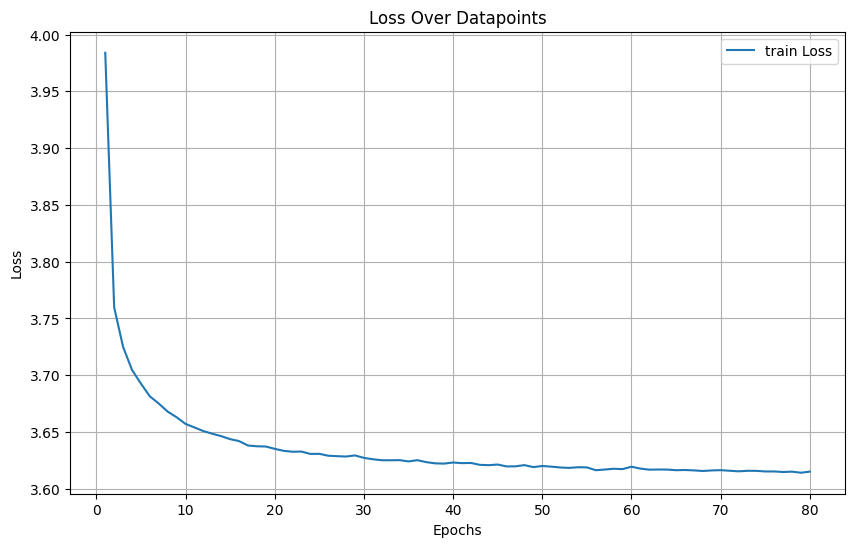

<Figure size 640x480 with 0 Axes>

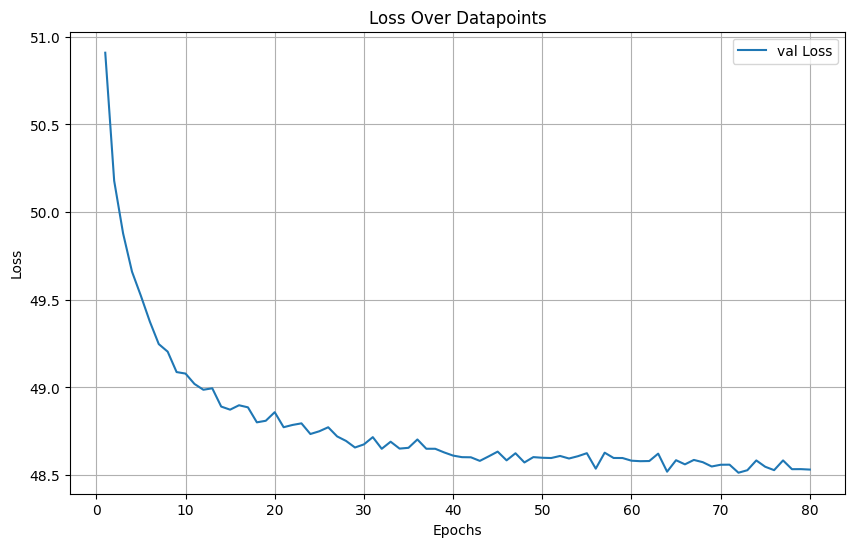

Training:  90%|█████████ | 90/100 [51:01<05:28, 32.89s/epoch, Patience=0 / 30]

Evaluating Model at Epoch 90



100%|██████████| 17/17 [00:00<00:00, 46.23it/s]


Accuracy 66.69769287109375



100%|██████████| 17/17 [00:00<00:00, 46.69it/s]

Accuracy 66.69769287109375
Accuracy of baseline is 66.70% at epoch 90


<Figure size 640x480 with 0 Axes>

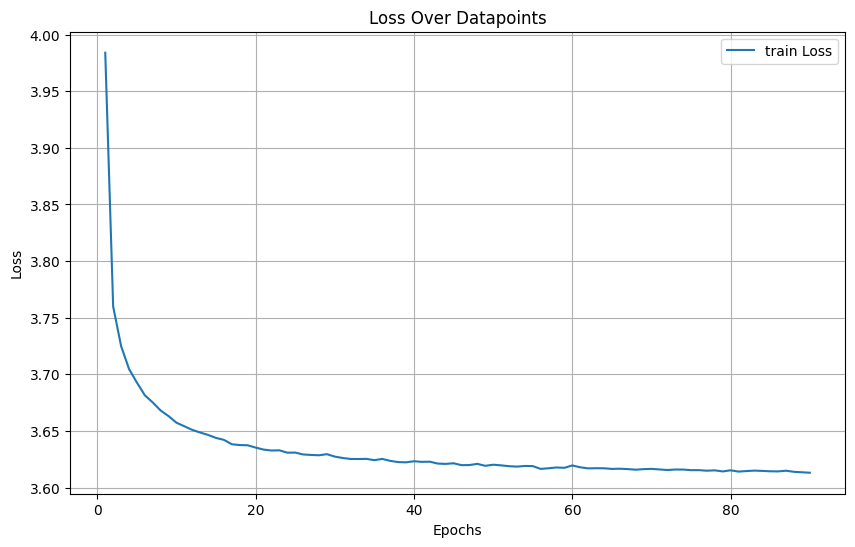

<Figure size 640x480 with 0 Axes>

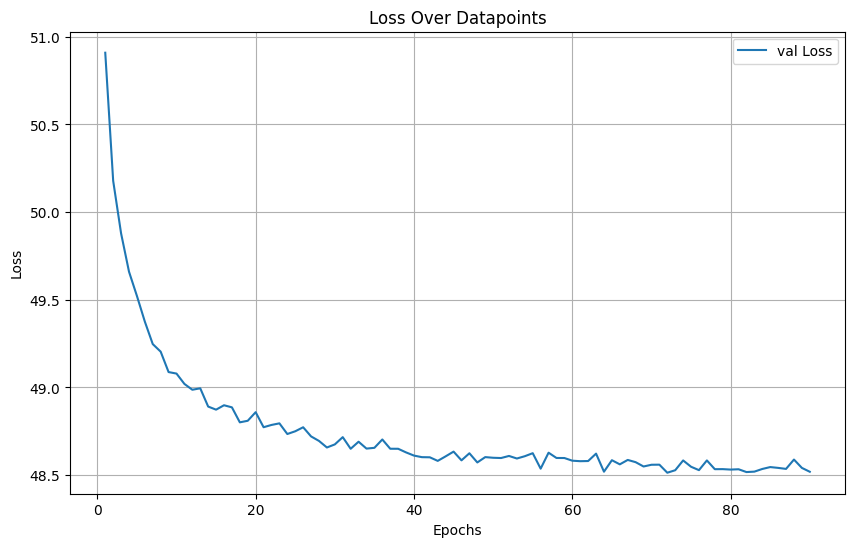

100%|██████████| 17/17 [00:00<00:00, 57.56it/s]


Accuracy 66.44170379638672


<Figure size 640x480 with 0 Axes>

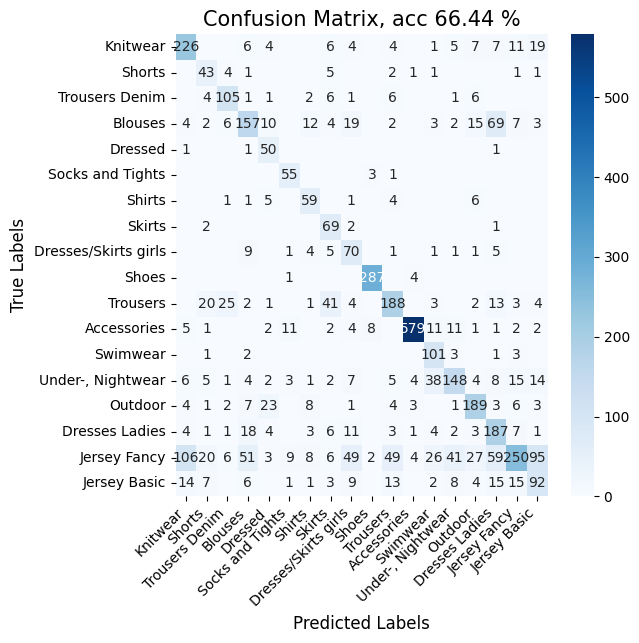

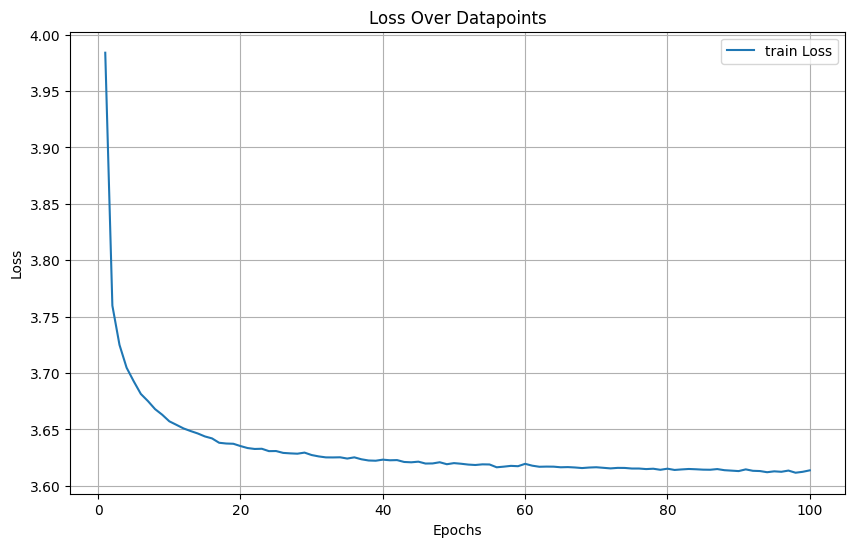

<Figure size 640x480 with 0 Axes>

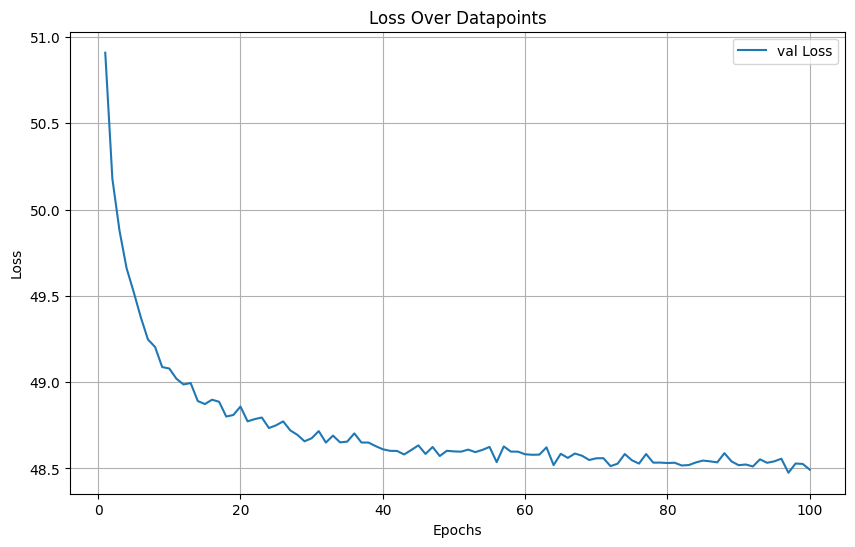

Accuracy for draft-experiments/weighted=True_hard-mining=False_fc=False is 66.44%
text_model.encoder.layers.10.self_attn.k_proj.lora_A
text_model.encoder.layers.10.self_attn.k_proj.lora_B
text_model.encoder.layers.10.self_attn.v_proj.lora_A
text_model.encoder.layers.10.self_attn.v_proj.lora_B
text_model.encoder.layers.10.self_attn.q_proj.lora_A
text_model.encoder.layers.10.self_attn.q_proj.lora_B
text_model.encoder.layers.10.self_attn.out_proj.lora_A
text_model.encoder.layers.10.self_attn.out_proj.lora_B
text_model.encoder.layers.11.self_attn.k_proj.lora_A
text_model.encoder.layers.11.self_attn.k_proj.lora_B
text_model.encoder.layers.11.self_attn.v_proj.lora_A
text_model.encoder.layers.11.self_attn.v_proj.lora_B
text_model.encoder.layers.11.self_attn.q_proj.lora_A
text_model.encoder.layers.11.self_attn.q_proj.lora_B
text_model.encoder.layers.11.self_attn.out_proj.lora_A
text_model.encoder.layers.11.self_attn.out_proj.lora_B


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Suggested threshold for hard examples: 4.754188981643042
Epoch 0: Max loss encountered = 7.189242362976074, Hard sample threshold set to 5.75139389038086


Training:  10%|█         | 10/100 [05:47<52:21, 34.90s/epoch, Patience=0 / 30]

Suggested threshold for hard examples: 3.7880416992690082
Epoch 10: Max loss encountered = 3.819091796875, Hard sample threshold set to 3.0552734375000004


Training:  11%|█         | 11/100 [06:24<52:45, 35.56s/epoch, Patience=1 / 30]

Epoch 11: Training on hard samples - Max allowed = 480, Current count = 229


Training:  12%|█▏        | 12/100 [07:16<59:28, 40.55s/epoch, Patience=0 / 30]

Epoch 12: Training on hard samples - Max allowed = 480, Current count = 458


Training:  13%|█▎        | 13/100 [08:29<1:13:14, 50.51s/epoch, Patience=1 / 30]

Epoch 13: Training on hard samples - Max allowed = 480, Current count = 480


Training:  14%|█▍        | 14/100 [09:40<1:21:21, 56.76s/epoch, Patience=0 / 30]

Epoch 14: Training on hard samples - Max allowed = 480, Current count = 480


Training:  15%|█▌        | 15/100 [10:55<1:28:08, 62.22s/epoch, Patience=1 / 30]

Epoch 15: Training on hard samples - Max allowed = 480, Current count = 480


Training:  16%|█▌        | 16/100 [12:06<1:30:50, 64.89s/epoch, Patience=0 / 30]

Epoch 16: Training on hard samples - Max allowed = 480, Current count = 480


Training:  17%|█▋        | 17/100 [13:21<1:33:55, 67.90s/epoch, Patience=1 / 30]

Epoch 17: Training on hard samples - Max allowed = 480, Current count = 480


Training:  18%|█▊        | 18/100 [14:33<1:34:35, 69.21s/epoch, Patience=2 / 30]

Epoch 18: Training on hard samples - Max allowed = 500, Current count = 500


Training:  19%|█▉        | 19/100 [15:46<1:34:57, 70.34s/epoch, Patience=0 / 30]

Epoch 19: Training on hard samples - Max allowed = 500, Current count = 500


Training:  20%|██        | 20/100 [17:04<1:36:30, 72.38s/epoch, Patience=1 / 30]

Suggested threshold for hard examples: 3.7491762572538825
Epoch 20: Max loss encountered = 3.800816297531128, Hard sample threshold set to 3.0406530380249026
Epoch 20: Training on hard samples - Max allowed = 490, Current count = 490


Training:  21%|██        | 21/100 [18:16<1:35:15, 72.35s/epoch, Patience=2 / 30]

Epoch 21: Training on hard samples - Max allowed = 510, Current count = 510


Training:  22%|██▏       | 22/100 [19:29<1:34:32, 72.73s/epoch, Patience=3 / 30]

Epoch 22: Training on hard samples - Max allowed = 510, Current count = 510


Training:  23%|██▎       | 23/100 [20:43<1:33:30, 72.86s/epoch, Patience=0 / 30]

Epoch 23: Training on hard samples - Max allowed = 510, Current count = 510


Training:  24%|██▍       | 24/100 [22:00<1:34:00, 74.22s/epoch, Patience=1 / 30]

Epoch 24: Training on hard samples - Max allowed = 530, Current count = 530


Training:  25%|██▌       | 25/100 [23:16<1:33:23, 74.72s/epoch, Patience=0 / 30]

Epoch 25: Training on hard samples - Max allowed = 530, Current count = 530


Training:  26%|██▌       | 26/100 [24:36<1:33:59, 76.21s/epoch, Patience=1 / 30]

Epoch 26: Training on hard samples - Max allowed = 530, Current count = 530


Training:  27%|██▋       | 27/100 [25:51<1:32:28, 76.01s/epoch, Patience=2 / 30]

Epoch 27: Training on hard samples - Max allowed = 550, Current count = 550


Training:  28%|██▊       | 28/100 [27:08<1:31:36, 76.33s/epoch, Patience=0 / 30]

Epoch 28: Training on hard samples - Max allowed = 550, Current count = 550


Training:  29%|██▉       | 29/100 [28:29<1:31:48, 77.58s/epoch, Patience=1 / 30]

Epoch 29: Training on hard samples - Max allowed = 570, Current count = 570


Training:  30%|███       | 30/100 [29:47<1:30:39, 77.71s/epoch, Patience=2 / 30]

Suggested threshold for hard examples: 3.7548099384048252
Epoch 30: Max loss encountered = 3.782806634902954, Hard sample threshold set to 3.0262453079223635
Epoch 30: Training on hard samples - Max allowed = 590, Current count = 590


Training:  31%|███       | 31/100 [31:06<1:30:04, 78.33s/epoch, Patience=0 / 30]

Epoch 31: Training on hard samples - Max allowed = 590, Current count = 590


Training:  32%|███▏      | 32/100 [32:30<1:30:39, 79.99s/epoch, Patience=1 / 30]

Epoch 32: Training on hard samples - Max allowed = 590, Current count = 590


Training:  33%|███▎      | 33/100 [33:51<1:29:30, 80.15s/epoch, Patience=0 / 30]

Epoch 33: Training on hard samples - Max allowed = 590, Current count = 590


Training:  34%|███▍      | 34/100 [35:15<1:29:36, 81.46s/epoch, Patience=1 / 30]

Epoch 34: Training on hard samples - Max allowed = 610, Current count = 610


Training:  35%|███▌      | 35/100 [36:37<1:28:22, 81.57s/epoch, Patience=2 / 30]

Epoch 35: Training on hard samples - Max allowed = 630, Current count = 630


Training:  36%|███▌      | 36/100 [38:01<1:27:37, 82.14s/epoch, Patience=3 / 30]

Epoch 36: Training on hard samples - Max allowed = 630, Current count = 630


Training:  37%|███▋      | 37/100 [39:23<1:26:25, 82.30s/epoch, Patience=4 / 30]

Epoch 37: Training on hard samples - Max allowed = 650, Current count = 650


Training:  38%|███▊      | 38/100 [40:48<1:25:43, 82.96s/epoch, Patience=5 / 30]

Epoch 38: Training on hard samples - Max allowed = 650, Current count = 650


Training:  39%|███▉      | 39/100 [42:13<1:24:55, 83.53s/epoch, Patience=0 / 30]

Epoch 39: Training on hard samples - Max allowed = 650, Current count = 650


Training:  40%|████      | 40/100 [43:42<1:25:08, 85.14s/epoch, Patience=1 / 30]

Suggested threshold for hard examples: 3.738315954428396
Epoch 40: Max loss encountered = 3.7857284545898438, Hard sample threshold set to 3.028582763671875
Epoch 40: Training on hard samples - Max allowed = 640, Current count = 640


Training:  41%|████      | 41/100 [45:07<1:23:39, 85.08s/epoch, Patience=2 / 30]

Epoch 41: Training on hard samples - Max allowed = 660, Current count = 660


Training:  42%|████▏     | 42/100 [46:33<1:22:30, 85.36s/epoch, Patience=3 / 30]

Epoch 42: Training on hard samples - Max allowed = 680, Current count = 680


Training:  43%|████▎     | 43/100 [48:00<1:21:36, 85.90s/epoch, Patience=4 / 30]

Epoch 43: Training on hard samples - Max allowed = 680, Current count = 680


Training:  44%|████▍     | 44/100 [49:27<1:20:29, 86.24s/epoch, Patience=5 / 30]

Epoch 44: Training on hard samples - Max allowed = 700, Current count = 700


Training:  45%|████▌     | 45/100 [50:55<1:19:35, 86.82s/epoch, Patience=6 / 30]

Epoch 45: Training on hard samples - Max allowed = 700, Current count = 700


Training:  46%|████▌     | 46/100 [52:24<1:18:45, 87.51s/epoch, Patience=7 / 30]

Epoch 46: Training on hard samples - Max allowed = 700, Current count = 700


Training:  47%|████▋     | 47/100 [53:54<1:17:50, 88.12s/epoch, Patience=0 / 30]

Epoch 47: Training on hard samples - Max allowed = 700, Current count = 700


Training:  48%|████▊     | 48/100 [55:27<1:17:43, 89.69s/epoch, Patience=1 / 30]

Epoch 48: Training on hard samples - Max allowed = 720, Current count = 720


Training:  49%|████▉     | 49/100 [56:57<1:16:14, 89.70s/epoch, Patience=0 / 30]

Epoch 49: Training on hard samples - Max allowed = 720, Current count = 720


Training:  50%|█████     | 50/100 [58:27<1:14:54, 89.89s/epoch, Patience=1 / 30]

Suggested threshold for hard examples: 3.7330686542911704
Epoch 50: Max loss encountered = 3.7818429470062256, Hard sample threshold set to 3.0254743576049807
Epoch 50: Training on hard samples - Max allowed = 710, Current count = 710


Training:  51%|█████     | 51/100 [59:57<1:13:28, 89.96s/epoch, Patience=0 / 30]

Epoch 51: Training on hard samples - Max allowed = 710, Current count = 710


Training:  52%|█████▏    | 52/100 [1:01:31<1:12:55, 91.16s/epoch, Patience=1 / 30]

Epoch 52: Training on hard samples - Max allowed = 730, Current count = 730


Training:  53%|█████▎    | 53/100 [1:03:03<1:11:36, 91.41s/epoch, Patience=2 / 30]

Epoch 53: Training on hard samples - Max allowed = 750, Current count = 750


Training:  54%|█████▍    | 54/100 [1:04:37<1:10:39, 92.17s/epoch, Patience=0 / 30]

Epoch 54: Training on hard samples - Max allowed = 750, Current count = 750


Training:  55%|█████▌    | 55/100 [1:06:13<1:10:03, 93.40s/epoch, Patience=1 / 30]

Epoch 55: Training on hard samples - Max allowed = 750, Current count = 750


Training:  56%|█████▌    | 56/100 [1:07:46<1:08:20, 93.18s/epoch, Patience=2 / 30]

Epoch 56: Training on hard samples - Max allowed = 770, Current count = 770


Training:  57%|█████▋    | 57/100 [1:09:21<1:07:05, 93.63s/epoch, Patience=3 / 30]

Epoch 57: Training on hard samples - Max allowed = 790, Current count = 790


Training:  58%|█████▊    | 58/100 [1:10:57<1:06:09, 94.51s/epoch, Patience=0 / 30]

Epoch 58: Training on hard samples - Max allowed = 790, Current count = 790


Training:  59%|█████▉    | 59/100 [1:12:38<1:05:47, 96.28s/epoch, Patience=1 / 30]

Epoch 59: Training on hard samples - Max allowed = 790, Current count = 790


Training:  60%|██████    | 60/100 [1:14:15<1:04:20, 96.50s/epoch, Patience=2 / 30]

Suggested threshold for hard examples: 3.7374541128964776
Epoch 60: Max loss encountered = 3.797853469848633, Hard sample threshold set to 3.0382827758789066
Epoch 60: Training on hard samples - Max allowed = 810, Current count = 810


Training:  61%|██████    | 61/100 [1:15:52<1:02:55, 96.81s/epoch, Patience=0 / 30]

Epoch 61: Training on hard samples - Max allowed = 810, Current count = 810


Training:  62%|██████▏   | 62/100 [1:17:33<1:02:09, 98.14s/epoch, Patience=1 / 30]

Epoch 62: Training on hard samples - Max allowed = 830, Current count = 830


Training:  63%|██████▎   | 63/100 [1:19:13<1:00:48, 98.60s/epoch, Patience=0 / 30]

Epoch 63: Training on hard samples - Max allowed = 830, Current count = 830


Training:  64%|██████▍   | 64/100 [1:20:57<1:00:03, 100.11s/epoch, Patience=1 / 30]

Epoch 64: Training on hard samples - Max allowed = 830, Current count = 830


Training:  65%|██████▌   | 65/100 [1:22:37<58:21, 100.05s/epoch, Patience=2 / 30]  

Epoch 65: Training on hard samples - Max allowed = 850, Current count = 850


Training:  66%|██████▌   | 66/100 [1:24:18<56:56, 100.49s/epoch, Patience=3 / 30]

Epoch 66: Training on hard samples - Max allowed = 850, Current count = 850


Training:  67%|██████▋   | 67/100 [1:25:58<55:13, 100.40s/epoch, Patience=0 / 30]

Epoch 67: Training on hard samples - Max allowed = 850, Current count = 850


Training:  68%|██████▊   | 68/100 [1:27:43<54:11, 101.60s/epoch, Patience=1 / 30]

Epoch 68: Training on hard samples - Max allowed = 850, Current count = 850


Training:  69%|██████▉   | 69/100 [1:29:24<52:30, 101.64s/epoch, Patience=2 / 30]

Epoch 69: Training on hard samples - Max allowed = 870, Current count = 870


Training:  70%|███████   | 70/100 [1:31:07<51:01, 102.05s/epoch, Patience=3 / 30]

Suggested threshold for hard examples: 3.739425416627503
Epoch 70: Max loss encountered = 3.8019566535949707, Hard sample threshold set to 3.041565322875977
Epoch 70: Training on hard samples - Max allowed = 860, Current count = 860


Training:  71%|███████   | 71/100 [1:32:49<49:16, 101.96s/epoch, Patience=4 / 30]

Epoch 71: Training on hard samples - Max allowed = 860, Current count = 860


Training:  72%|███████▏  | 72/100 [1:34:31<47:31, 101.85s/epoch, Patience=5 / 30]

Epoch 72: Training on hard samples - Max allowed = 880, Current count = 880


Training:  73%|███████▎  | 73/100 [1:36:11<45:38, 101.42s/epoch, Patience=6 / 30]

Epoch 73: Training on hard samples - Max allowed = 900, Current count = 900


Training:  74%|███████▍  | 74/100 [1:37:55<44:19, 102.28s/epoch, Patience=7 / 30]

Epoch 74: Training on hard samples - Max allowed = 900, Current count = 900


Training:  75%|███████▌  | 75/100 [1:39:38<42:40, 102.40s/epoch, Patience=8 / 30]

Epoch 75: Training on hard samples - Max allowed = 900, Current count = 900


Training:  76%|███████▌  | 76/100 [1:41:19<40:44, 101.86s/epoch, Patience=9 / 30]

Epoch 76: Training on hard samples - Max allowed = 920, Current count = 920


Training:  77%|███████▋  | 77/100 [1:43:01<39:05, 101.98s/epoch, Patience=0 / 30]

Epoch 77: Training on hard samples - Max allowed = 920, Current count = 920


Training:  78%|███████▊  | 78/100 [1:44:50<38:09, 104.06s/epoch, Patience=1 / 30]

Epoch 78: Training on hard samples - Max allowed = 940, Current count = 940


Training:  79%|███████▉  | 79/100 [1:46:39<36:53, 105.43s/epoch, Patience=0 / 30]

Epoch 79: Training on hard samples - Max allowed = 940, Current count = 940


Training:  80%|████████  | 80/100 [1:48:30<35:45, 107.29s/epoch, Patience=1 / 30]

Suggested threshold for hard examples: 3.737172088848044
Epoch 80: Max loss encountered = 3.818019390106201, Hard sample threshold set to 3.054415512084961
Epoch 80: Training on hard samples - Max allowed = 930, Current count = 930
Evaluating Model at Epoch 80



100%|██████████| 17/17 [00:00<00:00, 46.35it/s]


Accuracy 67.0700454711914



100%|██████████| 17/17 [00:00<00:00, 45.75it/s]

Accuracy 67.0700454711914
Accuracy of baseline is 67.07% at epoch 80


<Figure size 640x480 with 0 Axes>

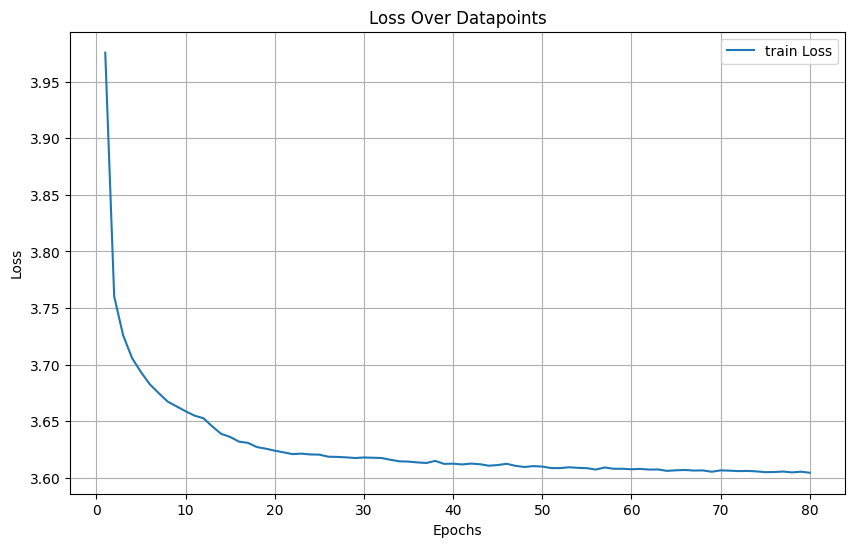

<Figure size 640x480 with 0 Axes>

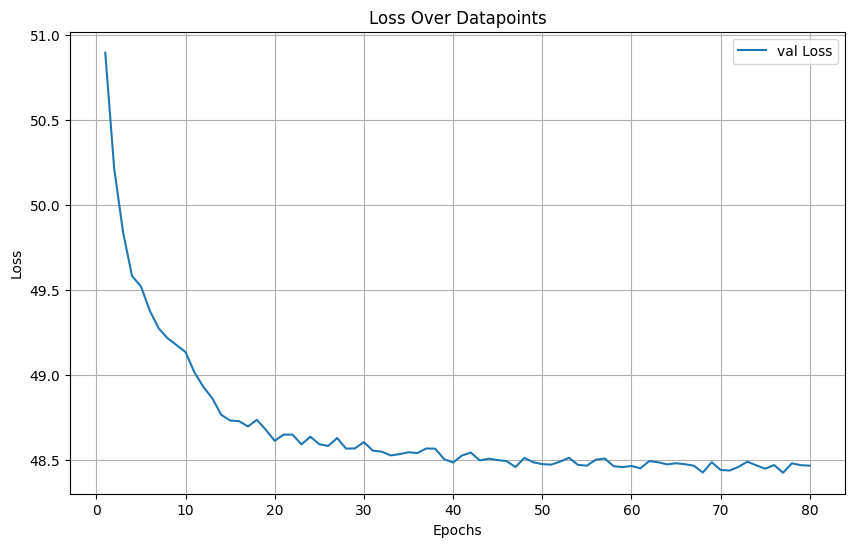

Training:  81%|████████  | 81/100 [1:50:20<34:13, 108.07s/epoch, Patience=2 / 30]

Epoch 81: Training on hard samples - Max allowed = 950, Current count = 950


Training:  82%|████████▏ | 82/100 [1:52:09<32:30, 108.33s/epoch, Patience=3 / 30]

Epoch 82: Training on hard samples - Max allowed = 970, Current count = 970


Training:  83%|████████▎ | 83/100 [1:54:00<30:54, 109.11s/epoch, Patience=0 / 30]

Epoch 83: Training on hard samples - Max allowed = 970, Current count = 970


Training:  84%|████████▍ | 84/100 [1:55:55<29:33, 110.85s/epoch, Patience=1 / 30]

Epoch 84: Training on hard samples - Max allowed = 970, Current count = 970


Training:  85%|████████▌ | 85/100 [1:57:45<27:41, 110.79s/epoch, Patience=2 / 30]

Epoch 85: Training on hard samples - Max allowed = 990, Current count = 990


Training:  86%|████████▌ | 86/100 [1:59:38<25:58, 111.34s/epoch, Patience=0 / 30]

Epoch 86: Training on hard samples - Max allowed = 990, Current count = 990


Training:  87%|████████▋ | 87/100 [2:01:34<24:23, 112.59s/epoch, Patience=1 / 30]

Epoch 87: Training on hard samples - Max allowed = 1010, Current count = 1010


Training:  88%|████████▊ | 88/100 [2:03:27<22:34, 112.91s/epoch, Patience=0 / 30]

Epoch 88: Training on hard samples - Max allowed = 1010, Current count = 1010


Training:  89%|████████▉ | 89/100 [2:05:26<21:01, 114.68s/epoch, Patience=1 / 30]

Epoch 89: Training on hard samples - Max allowed = 1030, Current count = 1030


Training:  90%|█████████ | 90/100 [2:07:18<18:59, 113.94s/epoch, Patience=2 / 30]

Suggested threshold for hard examples: 3.7344722007152873
Epoch 90: Max loss encountered = 3.8323020935058594, Hard sample threshold set to 3.0658416748046875
Epoch 90: Training on hard samples - Max allowed = 1050, Current count = 1050
Evaluating Model at Epoch 90



100%|██████████| 17/17 [00:00<00:00, 53.53it/s]


Accuracy 67.0700454711914



100%|██████████| 17/17 [00:00<00:00, 55.38it/s]


Accuracy 67.0700454711914
Accuracy of baseline is 67.07% at epoch 90


<Figure size 640x480 with 0 Axes>

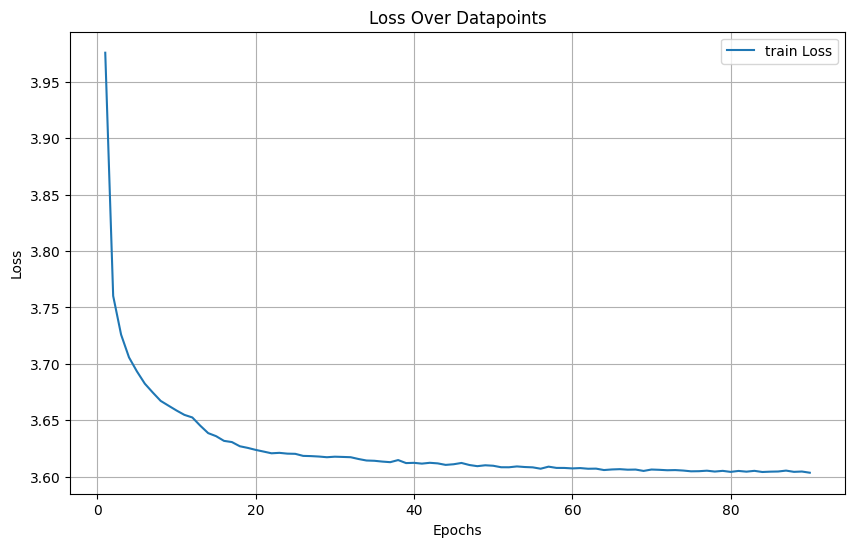

<Figure size 640x480 with 0 Axes>

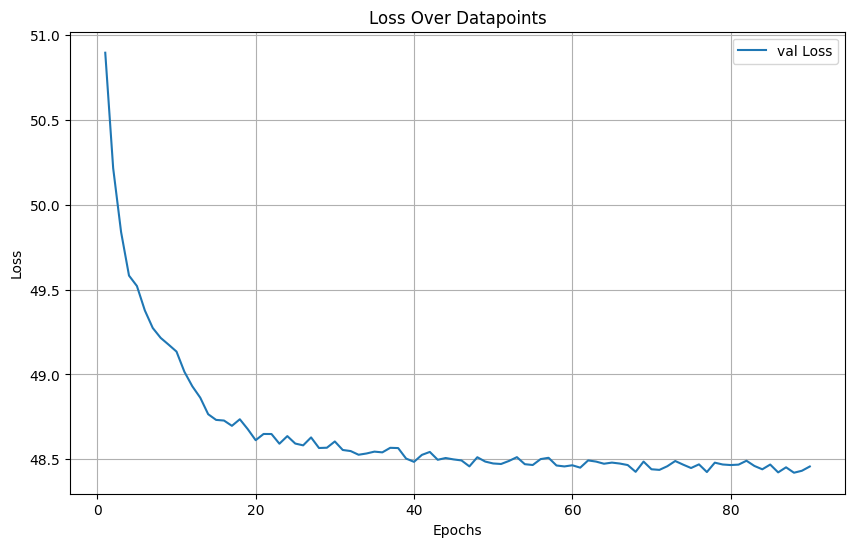

Training:  91%|█████████ | 91/100 [2:09:12<17:04, 113.89s/epoch, Patience=0 / 30]

Epoch 91: Training on hard samples - Max allowed = 1050, Current count = 1050


Training:  92%|█████████▏| 92/100 [2:11:08<15:14, 114.35s/epoch, Patience=1 / 30]

Epoch 92: Training on hard samples - Max allowed = 1070, Current count = 1070


Training:  93%|█████████▎| 93/100 [2:13:01<13:18, 114.10s/epoch, Patience=0 / 30]

Epoch 93: Training on hard samples - Max allowed = 1070, Current count = 1070


Training:  94%|█████████▍| 94/100 [2:14:59<11:30, 115.15s/epoch, Patience=1 / 30]

Epoch 94: Training on hard samples - Max allowed = 1090, Current count = 1090


Training:  95%|█████████▌| 95/100 [2:16:54<09:35, 115.10s/epoch, Patience=2 / 30]

Epoch 95: Training on hard samples - Max allowed = 1110, Current count = 1110


Training:  96%|█████████▌| 96/100 [2:18:50<07:42, 115.61s/epoch, Patience=3 / 30]

Epoch 96: Training on hard samples - Max allowed = 1110, Current count = 1110


Training:  97%|█████████▋| 97/100 [2:20:47<05:47, 115.90s/epoch, Patience=0 / 30]

Epoch 97: Training on hard samples - Max allowed = 1110, Current count = 1110


Training:  98%|█████████▊| 98/100 [2:22:47<03:54, 117.24s/epoch, Patience=1 / 30]

Epoch 98: Training on hard samples - Max allowed = 1130, Current count = 1130


Training:  99%|█████████▉| 99/100 [2:24:46<01:57, 117.77s/epoch, Patience=2 / 30]

Epoch 99: Training on hard samples - Max allowed = 1150, Current count = 1150


100%|██████████| 17/17 [00:00<00:00, 63.33it/s]


Accuracy 66.62787628173828


<Figure size 640x480 with 0 Axes>

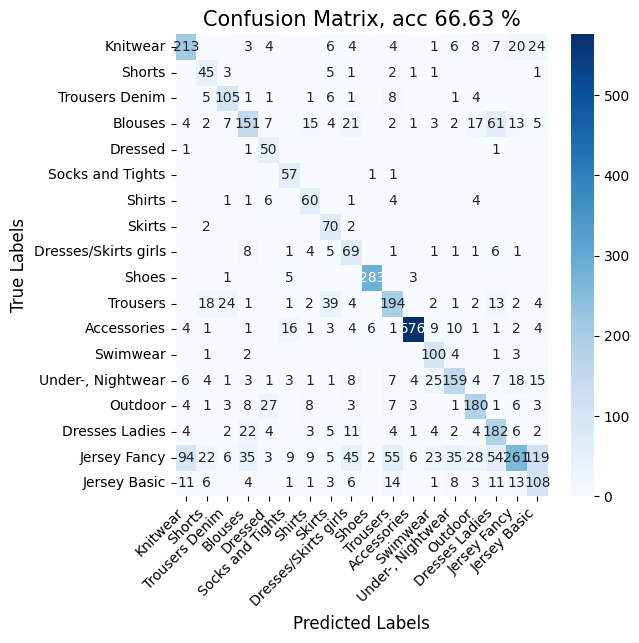

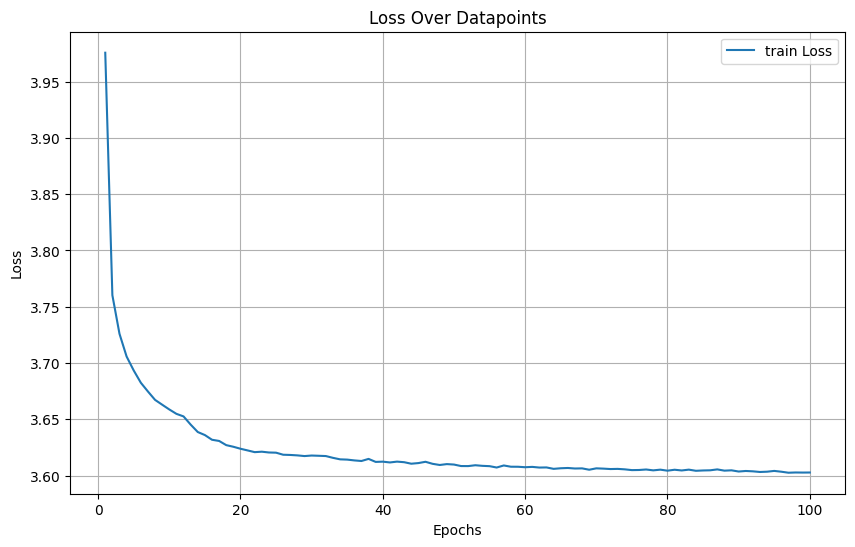

<Figure size 640x480 with 0 Axes>

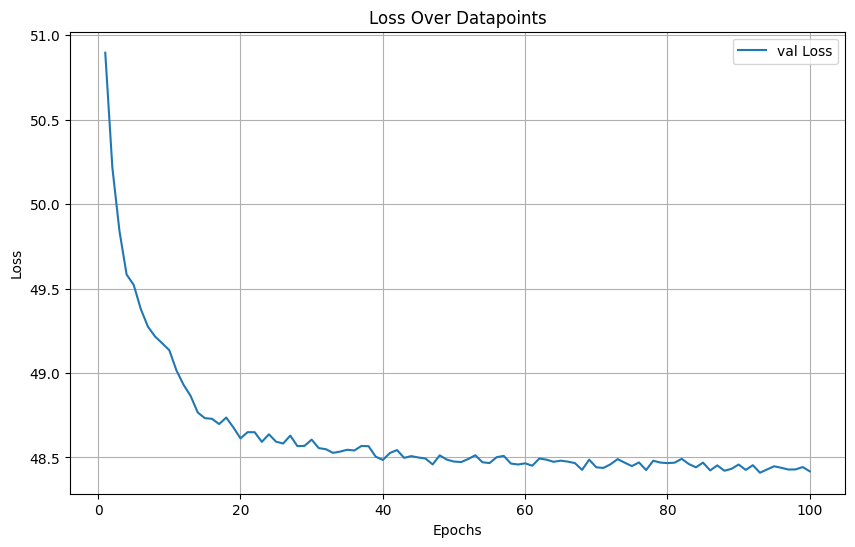

Accuracy for draft-experiments/weighted=True_hard-mining=True_fc=False is 66.63%


<Figure size 640x480 with 0 Axes>

In [ ]:
for weighted in [False, True]:
    for hard_mining in [False, True]:
        run_lora(weighted, hard_mining)